# 강화학습(RL - Reinforcement Learning)
- 강화학습은 앞에서 살펴본 지도학습이나 비지도학습 모델과는 매우 다르다.
- 백지상태(즉, 사전 정보가 없는)에서 시작해 RL 에이전트는 히트와 시행의 여러 단계를 거치며 목표를 달성하는 방법을 배울 수 있고, 학습하는 동안의 유일한 입력은 환경에서 받는 피드백이다.
- 걸음마를 배우는 아기, 하늘을 나는 법을 배우는 새, 또는 아타리 게임을 배우는 RL 에이전트 사이의 공통점은 무엇일까? 이 세 가지는 다음과 같이 모두 연계돼 있다.
1. 시행착오 : 아이(또는 새)는 다양한 방법을 시도하고, 여러 번 실패하며, 실제로 서거나 날 때까지 어떻게든 성공한다. RL 에이전트는 많은 게임을 하면서 이기기도 하고 많이 지기도 하면서 안정적으로 성공에 이르게 된다.
2. 목표 : 아이의 목표는 걷는 것, 새의 목표는 나는 것, RL 에이전트의 목표는 게임에서 이기는 것이다.
3. 환경과 상호작용 : 유일한 피드백은 환경에서 얻는 것이다.

### RL의 용어와 설명

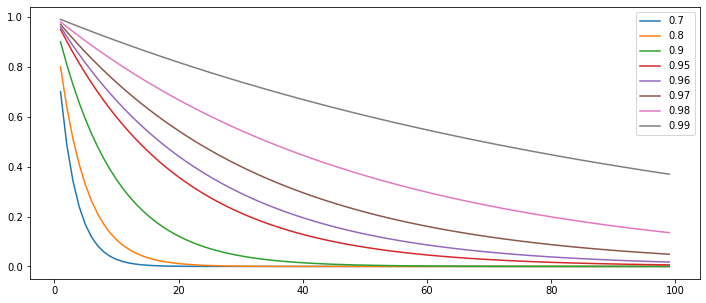

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xs = np.array(range(1,100))
gammas = [0.7,0.8,0.9,0.95,0.96,0.97,0.98,0.99]

plt.figure(figsize=(12,5))
for g in gammas:
    ys = pow(g, xs)
    plt.plot(xs,ys)
plt.legend(gammas)
plt.show()

- 0.7일때 비율이 낮아지다가 미래 $10회차$ 이후의 보상은 거의 고려하지 않는다.
- 0.8일때 비율이 낮아지다가 미래 $20회차$ 이후의 보상은 거의 고려하지 않는다.
- 0.9일때 비율이 낮아지다가 미래 $40회차$ 이후의 보상은 거의 고려하지 않는다.

In [21]:
# 현 설치 상태에서 가용한 환경 목록을 보고자 이 명령을 사용한다.
# 설치된 모든 환경 목록과 해당 환경 ID가 출력 된다.
from gym import envs
print(envs.registry.all())

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [22]:
import gym
env_name = 'Breakout-v0'
env = gym.make(env_name)

In [23]:
obs = env.reset()
env.render()

True

In [24]:
env.close()

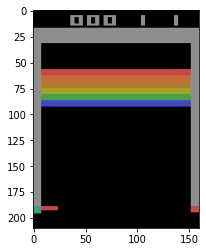

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(env.render(mode='rgb_array'))

In [42]:
# height : 210
# width : 160
# channel : 3(RGB)
print(env.observation_space)

Box(210, 160, 3)


In [43]:
print(env.action_space)

Discrete(4)


In [44]:
env.close()

In [30]:
# matplotlib 을 사용하여 게임을 저장 하는 방법
import gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation

env_name = 'Breakout-v0'
env = gym.make(env_name)

In [39]:
frames = []  # 각 단계에서 상태 공간을 저장할 배열

env.reset()
done = False
for _ in range(300):
    frames.append(env.render(mode='rgb_array'))
    obs, reward, done, _ = env.step(env.action_space.sample())
    if done:
        break

patch = plt.imshow(frames[0])
plt.axis('off')
def animate(i):
    patch.set_data(frames[i])
anim = animation.FuncAnimation(plt.gcf(), animate, \
        frames=len(frames), interval=10)
anim.save('random_agent.gif', writer='imagemagick')

TypeError: 'MovieWriterRegistry' object is not an iterator

In [35]:
# 게임을 비디오로 저장하는 방법
import gym
env = gym.make('Breakout-v0')
env = gym.wrappers.Monitor(env, 'recording', force=True)
observation = env.reset()
for _ in range(1000):
    #env.render()
    action = env.action_space.sample()
    # 에이전트(랜덤 행동을 취한다)
    observation, reward, done, info = env.step(action)
    if done:
        observation = env.reset()
env.close()

## DQN(Deep Q-Networks) - CartPole 예제

In [1]:
import random
import gym
import math
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

EPOCHS = 1000
THRESHOLD = 45
MONITOR = True

In [2]:
class DQN():
    def __init__(self, env_string,batch_size=64):
        self.memory = deque(maxlen=100000)
        self.env = gym.make(env_string)
        input_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n
        self.batch_size = batch_size
        self.gamma = 1.0
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        alpha=0.01
        alpha_decay=0.01
        if MONITOR: self.env = gym.wrappers.Monitor(self.env, './RL_data/'+env_string, force=True)
        
        # 모델 초기화(Init model)
        self.model = Sequential()
        self.model.add(Dense(24, input_dim=input_size, activation='tanh'))
        self.model.add(Dense(48, activation='tanh'))
        self.model.add(Dense(action_size, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=alpha, decay=alpha_decay))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.model.predict(state))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model.predict(state)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        #epsilon = max(epsilon_min, epsilon_decay*epsilon) # decrease epsilon
       

    def train(self):
        scores = deque(maxlen=100)
        avg_scores = []
        

        for e in range(EPOCHS):
            state = self.env.reset()
            state = self.preprocess_state(state)
            done = False
            i = 0
            while not done:
                action = self.choose_action(state,self.epsilon)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon) # 엡실론 감소(decrease epsilon)
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            avg_scores.append(mean_score)
            if mean_score >= THRESHOLD and e >= 100:
                print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return avg_scores
            if e % 100 == 0:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            self.replay(self.batch_size)
        
        print('Did not solve after {} episodes 😞'.format(e))
        return avg_scores

In [3]:
env_string = 'CartPole-v0'
agent = DQN(env_string)
scores = agent.train()

[Episode 0] - Mean survival time over last 100 episodes was 16.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 26.15 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 38.33 ticks.
Ran 229 episodes. Solved after 129 trials ✔


In [4]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1200      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 98        
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
_________________________________________________________________


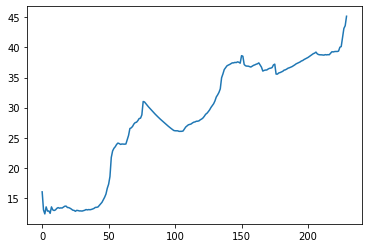

In [5]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()

In [6]:
agent.env.close()

## 아타리 게임용 DQN - Playing Atari with Deep Reinforcement Learning
- 대부분의 코드는 카트폴의 DQN과 유사하지만 DQN 신경망 자페와 환경에서 얻은 상태를 전처리하는 방법에 있어 상당한 변화가 있다.
- 우선 먼저 상태 공간이 처리되는 방식이 변화되는데, 다음 이미지에서 아타리 게임 중 하나인 Breakpout을 볼 수 있다.<br>
<img src='RL_data/atarigame-breakout.png'><br>
- 이제 이미지를 살펴보면 모든 이미지가 관련 정보를 포함하고 있지는 않다는 것을 알 수 있다.
- 상단에는 점수에 대한 불필요한 정보가 있고 하단에는 쓸모없는 빈 공간이 있으며 이미지는 컬러로 돼 있다.
- 모델의 부담을 줄이려면 불필요한 정보를 제거해야 함
- 따라서 이미지를 자르고 회색조로 변환하고 84 x 84 크기의 정사각형으로 만든다

In [10]:
import random
import gym
#import math
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

EPOCHS = 1000
THRESHOLD = 10
MONITOR = True

In [11]:
class DQN():
    ## 일부 변경됨(크기가 84x84x4인 4개의 상태 프레임을 나타내는 입력을 가진 CNN 신경망을 갖도록 함수를 수정함)
    def __init__(self, env_string,batch_size=64, IM_SIZE = 84, m = 4):
        self.memory = deque(maxlen=5000)
        self.env = gym.make(env_string)
        input_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n
        self.batch_size = batch_size
        self.gamma = 1.0
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.IM_SIZE = IM_SIZE
        self.m = m
       
        
        alpha=0.01
        alpha_decay=0.01
        if MONITOR: self.env = gym.wrappers.Monitor(self.env, './RL_data/'+env_string, force=True)
        
        # Init model
        self.model = Sequential()
        self.model.add( Conv2D(32, 8, (4,4), activation='relu',padding='valid', input_shape=(IM_SIZE, IM_SIZE, m)))
        #self.model.add(MaxPooling2D())
        self.model.add( Conv2D(64, 4, (2,2), activation='relu',padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add( Conv2D(64, 3, (1,1), activation='relu',padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='elu'))
        self.model.add(Dense(action_size, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=alpha, decay=alpha_decay))
        self.model_target = tf.keras.models.clone_model(self.model)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.model.predict(state))

    ## 변경됨
    # 이미지를 자르고, 회색조로 변환, 84x84로 리사이징해주는 함수
    def preprocess_state(self, img):
        img_temp = img[31:195]  # Choose the important area of the image
        img_temp = tf.image.rgb_to_grayscale(img_temp)
        img_temp = tf.image.resize(img_temp, [self.IM_SIZE, self.IM_SIZE],
                                   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        img_temp = tf.cast(img_temp, tf.float32)
        return img_temp[:,:,0]

    ## 추가됨
    # 현재 상태와 이전 상태를 결합하는 함수
    def combine_images(self, img1, img2):
        if len(img1.shape) == 3 and img1.shape[0] == self.m:
            im = np.append(img1[1:,:, :],np.expand_dims(img2,0), axis=2)
            return tf.expand_dims(im, 0)
        else:
            im = np.stack([img1]*self.m, axis = 2)
            return tf.expand_dims(im, 0)
        #return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model_target.predict(state)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        #epsilon = max(epsilon_min, epsilon_decay*epsilon) # decrease epsilon
       

    def train(self):
        scores = deque(maxlen=100)
        avg_scores = []
        

        for e in range(EPOCHS):
            state = self.env.reset()
            state = self.preprocess_state(state)
            state = self.combine_images(state, state)
            done = False
            i = 0
            while not done:
                action = self.choose_action(state,self.epsilon)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                next_state = self.combine_images(next_state, state)
                #print(next_state.shape)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon) # decrease epsilon
                i += reward

            scores.append(i)
            mean_score = np.mean(scores)
            avg_scores.append(mean_score)
            if mean_score >= THRESHOLD:
                print('Solved after {} trials ✔'.format(e))
                return avg_scores
            if e % 10 == 0:
                print('[Episode {}] - Average Score: {}.'.format(e, mean_score))
                self.model_target.set_weights(self.model.get_weights())

            self.replay(self.batch_size)
        
        print('Did not solve after {} episodes 😞'.format(e))
        return avg_scores

In [12]:
env_string = 'BreakoutDeterministic-v4'
agent = DQN(env_string)

In [13]:
agent.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [14]:
agent.model_target.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [15]:
scores = agent.train()

[Episode 0] - Average Score: 2.0.
[Episode 10] - Average Score: 1.3636363636363635.
[Episode 20] - Average Score: 1.2380952380952381.


In [1]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()

NameError: name 'scores' is not defined

In [2]:
agent.env.close()

NameError: name 'agent' is not defined